In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 26a

## This is a simple implementation of GAN (Generative Adversarial Networks).
</p><img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

For ease of understanding, consider 2 x 2 black and white images. Correct image will have darker shades in diagonal and would look like a backslash.

In [2]:
### Import Libraries

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# some global variables

RANDOM_STATE = 24

np.random.RandomState(seed=RANDOM_STATE);

# input and output directories
inpDir = '../input'
outDir = '../output'

# Set the ploting parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          #'text.usetex':True,
          #'text.latex.unicode':True
         }

plt.rcParams.update(params)

# Hyperparameters
ALPHA = 0.01 # learning rate

EPOCHS = 1000

## Helper Functions

In [4]:
# Plot Images

def fn_plot_samples(samples, m, n):
    
    fig, axes = plt.subplots(figsize=(n*2, m*2), # as per the elements
                             nrows=m, ncols=n,  # columns and rows
                             sharey=True, sharex=True) # same axis for all images
    
    for ax, img in zip(axes.flatten(), samples):
        
        ax.xaxis.set_visible(False)
        
        ax.yaxis.set_visible(False)
        
        im = ax.imshow( 1 - img.reshape((2,2)), cmap='Greys_r')  # show images
        
    return fig, axes

## Sigmoid Activation Function

In [5]:
# The sigmoid activation function
def fn_sigmoid(x):
    '''
    Args:
        x: scalar or vector
    Return:
        Sigmoid value; scalar or vector
    '''
    return 1/(1.0 + np.exp(-x))

## Sample Faces

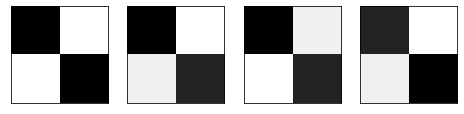

In [6]:
# Examples of faces

faces = [np.array ( [ 1.0, 0.0, 0.0, 1.0 ] ),
         np.array ( [ 0.9, 0.1, 0.2, 0.8 ] ),
         np.array ( [ 0.9, 0.2, 0.1, 0.8 ] ),
         np.array ( [ 0.8, 0.1, 0.2, 0.9 ] ),
         np.array ( [ 0.8, 0.2, 0.1, 0.9 ] )]
    
_ = fn_plot_samples(faces, 1, 4)

# Sample noise

The following are randomly generated images, which don't correspond to any face.


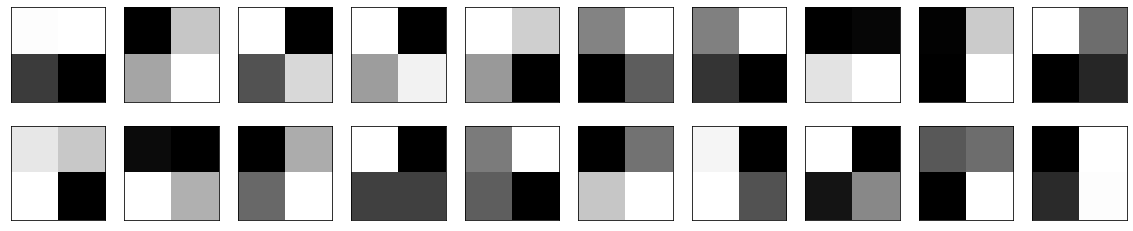

In [7]:
# Sample 20 noisy images

noise = [np.random.random((2,2)).round(2) for i in range(20)]

_ = fn_plot_samples(noise, 2,10)

## The neural network

### Loss Function
<p style="font-family: Arial; font-size:1.2em;color:black;">
We need to minimise the error by adjusting (W, b). A common choice for loss function with the softmax output is the cross-entropy loss. The loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:
</p>
<br>

$$
\begin{aligned}
L(\hat{y},y) & =  -y.log\hat{y} - (1-y) . log(1-\hat{y})\\
D(x) & = x_1 . w_1 + x_2 . w_2 + x_3 . w_3+ x_4 . w_4 + b \\
D(x) & = X . W + b\\
a & = \hat{y} = \mathrm{sigmoid}(z)\\
\end{aligned}
$$

### The Discriminator
<img src='images/s22_dnn_fig2a.png' width='500' alt="Image of single layer discriminator" align="left"/>

<p>In case of images, y = 1. Hence,</p>
<p>
$
\begin{aligned}
L(\hat{y},y) & =  -y \circ log\hat{y} - (1-y) \circ log(1-\hat{y})\\
L(\hat{y},1) & =  -1 \circ log\hat{y} - (1-1) \circ log(1-\hat{y})\\
L(\hat{y},1) & =  -log\hat{y}\\
\frac{\partial{L}}{\partial{w_i}} & = x_i \circ\ ( \hat{y} - 1) \\
\frac{\partial{L}}{\partial{b}} & = ( \hat{y} - 1) \\
\end{aligned}
$
    </p>

In case of noise, y = 0. Hence
        <br><br>
$
\begin{aligned}
L(\hat{y},y) & =  -y.log\hat{y} - (1-y) . log(1-\hat{y})\\
L(\hat{y},0) & =  -0.log\hat{y} - (1-0) . log(1-\hat{y})\\
L(\hat{y},1) & =  -log(1-\hat{y})\\
\frac{\partial{L}}{\partial{w_i}} & = x_i \circ\ \hat{y} \\
\frac{\partial{L}}{\partial{b}} & =  \hat{y} \\
\end{aligned}
$

In [8]:
nn_input_dim = 4

# Discriminator class
class Discriminator():
    
    def __init__(self):
        '''
            Initialize weights as per the dimensions of the incoming images
        '''
        self.weights = np.random.randn(nn_input_dim) / np.sqrt(nn_input_dim)
        
        self.bias = 0.0 # bias can be zero
        
    
    # Forward Pass
    def forward(self, x):
        '''
        Args:
            x : pixel value of the images or noise
        Returns:
            Activations from the discriminator using sigmoid
        '''
        
        return fn_sigmoid(np.dot(x, self.weights) + self.bias)
    
    
    # Forward calculation error
    def image_error(self, image):
        '''
        Args:
            image: pixel values of the image
        Return
            error: 
        '''
        
        prediction = self.forward(image)
        
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)
    
    
    # Derivative for image
    def derivatives_from_image(self, image):
        '''
        Args:
            image: pixel values of the image
        Return
            dW, db: Gradient of weights and bias
        '''
       
        y_pred = self.forward(image)
        
        dW = image * (y_pred -1) # (a - y) 
        
        db = y_pred-1
        
        return dW, db
    
    
    # Gradient updates
    def update_from_image(self, x):
        '''
        Args:
            x: image or noise data
        Return
            none
        '''
    
        dW, db = self.derivatives_from_image(x)
        
        self.weights -= learning_rate * dW
        
        self.bias -= learning_rate * db
        
        
    #Error from the noise    
    def noise_error(self, noise):
        '''
        Args:
            noise: pixel values of the noise
        Return
            error:error in the noise
        '''
        
        y_pred = self.forward(noise)
        
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-y_pred)
    
    
    # Derivatives from the noise
    def derivatives_from_noise(self, noise):
        '''
        Args:
            noise: pixel values of the noise
        Return
            dW, db: Gradient of weights and bias
        '''
        
        y_pred = self.forward(noise)
        
        dW = noise * y_pred
        
        db = y_pred
        
        return dW, db
    
    
    # Gradient update
    def update_from_noise(self, noise):
        '''
        Args:
            noise: pixel values of the noise
        Return
            none
        '''
        
        dW, db = self.derivatives_from_noise(noise)
        
        self.weights -= learning_rate * dW
        
        self.bias -= learning_rate * db

## Generator
For sigmoid, we know that:

$\dfrac{d}{dx}\sigma(x) = \sigma(x)(1 - \sigma(x))$

<img src='images/s22_dnn_fig3a.png' width='100%' alt="Image of single layer discriminator" align="left"/>

In [9]:
# Generator class
class Generator():
    
    def __init__(self):
        
        '''
            Initialize weights as per the dimensions of the incoming images
        '''
        self.weights = np.random.randn(nn_input_dim) / np.sqrt(nn_input_dim)
        self.biases = np.zeros(nn_input_dim) # as earlier bias can be zero

    # Forward pass
    def forward(self, z):
        
        '''
        Args:
            z : a random number to generate a fake face
        Returns:
            G : sigmoid ( z * W + b ) 
        '''
        
        return fn_sigmoid(z * self.weights + self.biases) # activations from generated image

    
    # Error Calculations
    def error(self, z, discriminator):
        
        '''
        Args:
            z : a random number to generate a fake face
            discriminator : Discriminator object
        Returns:
            G : sigmoid(Z.W +b)
        '''
        
        # generate X using this generator
        x = self.forward(z)
        
        # Pass through the discriminator to get y
        y = discriminator.forward(x)
        
        # Generator wants discriminator to predict it as image (y = 1)
        return -np.log(y)

    
    # Calculate the derivatives
    def derivatives(self, z, discriminator):
        
        '''
        Args:
            z : a random number to generate a fake face
            discriminator : Discriminator object
        Returns:
            dW, db : derivatobes of weights and biases
        '''
        
        # Get Discriminator weights and biases
        discriminator_weights = discriminator.weights
        
        discriminator_bias = discriminator.bias
        
        # forward pass of z
        x = self.forward(z) # activations from Generator 
        
        y = discriminator.forward(x) # activations from Generator submitted to Discriminator
        
        factor = - ( 1 - y ) * discriminator_weights * x *( 1 - x ) # -[ 1 - D(G(z))].W.Gi.(1-Gi)
        
        dW = factor * z # multiply factor by z
        
        db = factor
        
        return dW, db

    
    # Update generator weights
    def update(self, z, discriminator):
        
        '''
        Args:
            z : a random number to generate a fake face
            discriminator : Discriminator object
        Returns:
            updates the weights and biases
        '''
        
        # error_before = self.error(z, discriminator) # switch on for checking only
        
        dW, db = self.derivatives(z, discriminator)
        
        self.weights -= learning_rate * dW
        
        self.biases -= learning_rate * dW
        
        # error_after = self.error(z, discriminator) # switch on for checking only

In [10]:
# Hyperparameters
learning_rate = ALPHA
epochs = EPOCHS

# Instantiate the GAN
D = Discriminator()
G = Generator()

# Always a good idea to plot the errors
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):
    
    for face in faces:
        
        # Update the discriminator weights from the real face
        D.update_from_image(face)
    
        # Pick a random number to generate a fake face
        z = np.random.rand()

        # Calculate the discriminator error
        errors_discriminator.append(sum(D.image_error(face) + D.noise_error(z)))
        
        # Calculate the generator error
        errors_generator.append(G.error(z, D))
        
        # Build a fake face
        noise = G.forward(z)
        
        # Update the discriminator weights from the fake face
        D.update_from_noise(noise)
    
        # Update the generator weights from the fake face
        G.update(z, D)

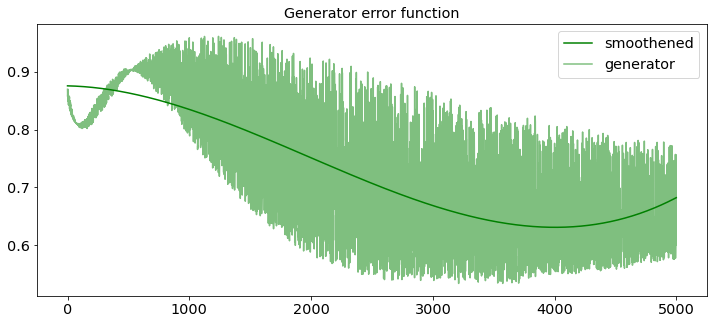

Text(0.5, 1.0, 'Discriminator error function')

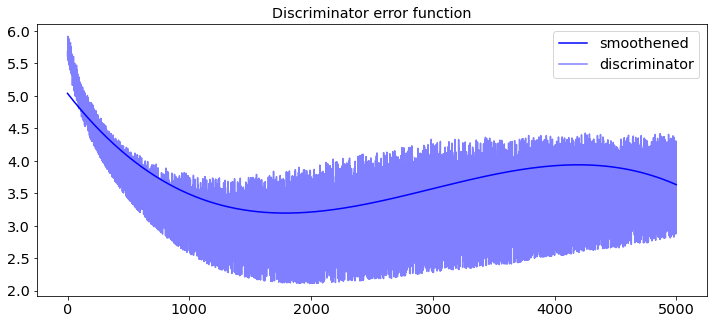

In [11]:
from scipy.interpolate import UnivariateSpline

# Plot generator errors
xnew = np.linspace(0, len(errors_generator)-1, 1000)   

spl = UnivariateSpline(range(len(errors_generator)), errors_generator)

#spl.set_smoothing_factor(1)

plt.plot(xnew, spl(xnew), '-', c='g', label = 'smoothened')

plt.plot(errors_generator, alpha = 0.5, c='g', label = 'generator')

plt.title("Generator error function")

plt.legend()

plt.show()

# Plot discrimenator errors
xnew = np.linspace(0, len(errors_discriminator)-1, 1000)  

spl = UnivariateSpline(range(len(errors_discriminator)), errors_discriminator)

#spl.set_smoothing_factor(500)

plt.plot(xnew, spl(xnew), '-', c='b', label = 'smoothened')

plt.plot(errors_discriminator, alpha = 0.5, c='b', label = 'discriminator')

plt.legend()

plt.title("Discriminator error function")


In [12]:
generated_images = []
for i in range(100):
    
    z = np.random.random() # generate a random number
    
    generated_image = G.forward(z) # call forward method of Generator class
    
    generated_images.append(generated_image)
    

#for i in generated_images:
#    print(i.round(2))

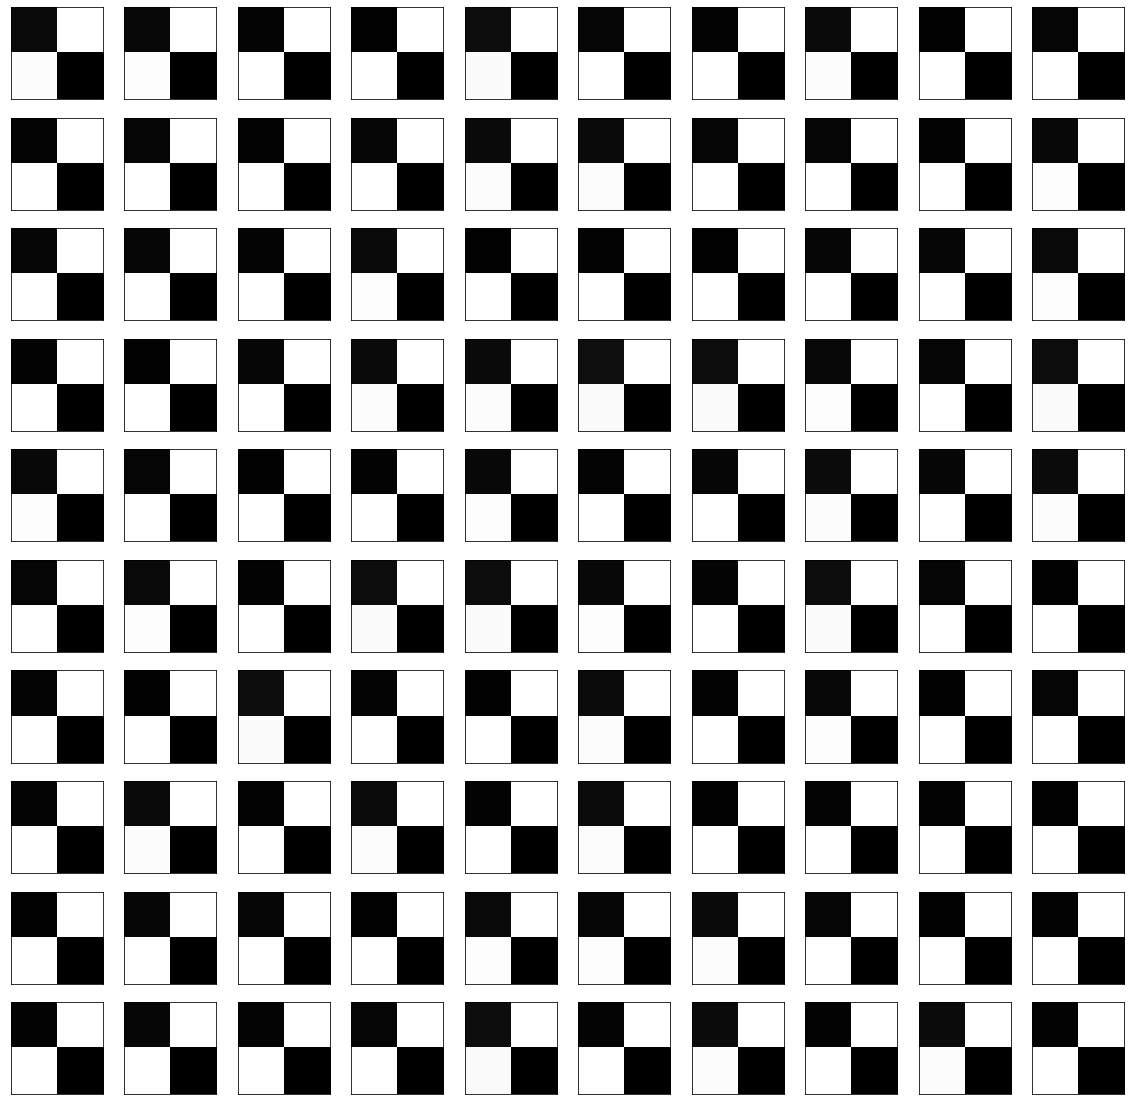

In [13]:
_ = fn_plot_samples(generated_images, 10, 10)

In [14]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [ 1.32035427 -1.7427181  -2.06740407  1.15703661]
Generator biases [ 1.65564848 -2.13932744 -1.85266606  1.98825259]


In [15]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [ 0.67373311 -1.17821453 -1.11116003  1.28684065]
Discriminator bias -1.596029490409425
